# Approximation

There are many cases where we end up with very high order models or models with dead time which we would like to approximate with lower order models or models without dead time. This sheet illustrates some of the approaches.

In [2]:
import sympy
sympy.init_printing()
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

## Taylor approximation

We have encountered Taylor approximants before. They are polynomial approximations and can easily be calculated using the `sympy.series` function.

## Padé approximation

Padé approximation is an extension of the concept of Taylor approximation with rational functions rather than polynomials. The basic premise is that the approximation is made by matching derivatives at a particular point. Padé approximants are often associated with dead time approximation, but can be used for arbitrary transfer functions as well.

In [3]:
a, b, c, s, D = sympy.symbols('a, b, c, s, D')
t = sympy.Symbol('t', positive=True)

We will approximate a Laplace dead time

In [4]:
G = sympy.exp(-2*s)
G

by a 1/1 Padé approximation. This means first order above the line and first order below. In order to force uniqueness of the solution, we force the constant term in the denominator to be unity.

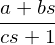

In [5]:
ga = (a + b*s)/(1 + c*s)
ga

We can solve for the parameters by setting the function value, first derivative and second derivative of the original function and the approximation to be equal at $s=0$.

In [6]:
s0 = 0
soln = sympy.solve([(G - ga).subs({s: s0}),
                    (G - ga).diff(s).subs({s: s0}),
                    (G - ga).diff(s, 2).subs({s: s0})], [a, b, c], dict=True)
soln

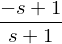

In [7]:
G_pade = ga.subs(soln[0])
G_pade

Compare this with a taylor approximation with same number of coefficients (matching the same number of derivatives)

In [8]:
G_taylor = G.series(s, s0, 3).removeO()
G_taylor

So how much do the approximations resemble the original function?

First, let's check just the real part

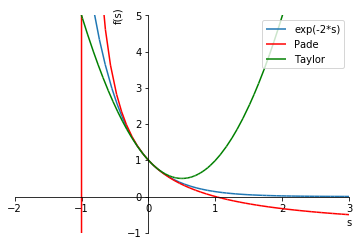

In [9]:
plotrange = (s, -2, 3)
def plot_approx(G, G_pade, G_taylor):
    p = sympy.plot(G, plotrange, show=False)
    pade_approx = sympy.plot(G_pade, plotrange, show=False, line_color='red')
    taylor_approx = sympy.plot(G_taylor, plotrange, show=False, line_color='green')
    p.extend(pade_approx)
    p.extend(taylor_approx)
    p[1].label = 'Pade'
    p[2].label = 'Taylor'
    p.ylim = (-1, 5)
    p.legend = True
    p.show()
plot_approx(G, G_pade, G_taylor)

Note the singularity in the Padé approximation, as well as the fact that the Taylor polynomial has an unbounded error to the right, while the Padé approximation is better behaved.

Now, let's see what this looks like for the whole complex plane

In [10]:
try:
    import mpmath
except ImportError:
    from sympy import mpmath

In [11]:
def cplot(G):
    f = sympy.lambdify(s, G, ['mpmath', 'numpy'])
    mpmath.cplot(f, [-2, 2], [-2, 2], points=10000)

The original function

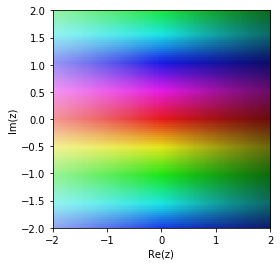

In [12]:
cplot(G)

Pade approximation

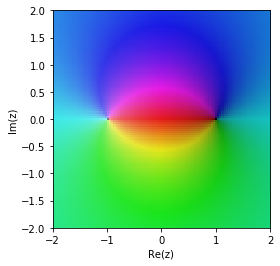

In [13]:
cplot(G_pade)

Taylor approximation

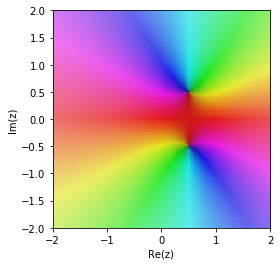

In [14]:
cplot(G_taylor)

The Pade approximation is much better in the region around 0.

Generalised function
=============

We can generalise the solution procedure to an arbitrary number of parameters

In [15]:
def pade(G, M, N, p=0):
    """ Return a Padé approximation of the function G, of order M/N around point p"""
    M += 1
    N += 1
    b = sympy.symbols('b:{}'.format(M))
    a = sympy.symbols('a:{}'.format(N))
    approximation = sum(b[i]*s**i for i in range(M))/sum(a[i]*s**i for i in range(N))
    nder = M + N
    derivatives = [(G - approximation).diff(s, i).subs({s: p}) for i in range(nder-1)]
    denominator_constant = [a[0] - 1]  # set denom constant term = 1
    equations = derivatives + denominator_constant
    pars = sympy.solve(equations, a + b, dict=True)
    return approximation.subs(pars[0])

Padé approximations with order 0 below the line are effectively Taylor polynomials

In [16]:
pade(G, 1, 0, 0)

This form is often used the other way around to approximate lags with dead time

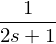

In [17]:
pade(G, 0, 1, 0)

In [18]:
def approx_comparison(G, M, N):
    P = pade(G, M, N, 0)
    T = sympy.series(G, s, 0, N+M+1).removeO()
    plot_approx(G, P, T)


In [19]:
from ipywidgets import interact

In [20]:
deadtime = sympy.exp(-2*s)
high_order = 1/(s + 1)**10

In [21]:
plotrange=(s, -5, 5)

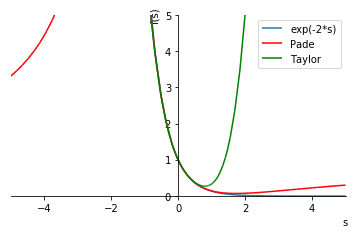

<function __main__.approx_comparison>

In [22]:
interact(approx_comparison, G=[deadtime, high_order], N=(1, 3), M=(1, 3))

## Approximations based on response matching

The approximations we discussed above are based on matching the values in the Laplace domain. However, we often want to find an approximation which has the property of matching the time domain responses.

A common-sense rule is that larger time constants are more important to retain than smaller ones. My personal rule is that any time constant which is less than 10 times smaller than the next largest one can usualy be ignored, in other words, for our purposes

$$ \frac{1}{(s + 1)(10s + 1)} \approx \frac{1}{10s + 1}$$

**Note** This is a rule of thumb and should not be applied during intermediate calculations. You should always be aware of the point where you are applying approximation and make a note that you have done this.

In this section I'll be using the [Python Control Systems Library](https://python-control.readthedocs.io/en/latest/). It doesn't support dead time in its transfer function object, but I'll fake it in the responses by shifting them with a certain dead time.

In [27]:
import control

I like defining `s` like this to make formulae easier to type later on. Note that this overwrites our earlier symbolic s, so after this definition we can no longer use s in sympy.

In [28]:
s = control.tf([1, 0], 1)

In [29]:
def plotstep(G, D=0, T=None):
    y, t = control.step(G, T=T)
    plt.plot(t+D, y)

In [30]:
G1 = 1/((s + 1)*(10*s + 1))
G2 = 1/((10*s + 1))

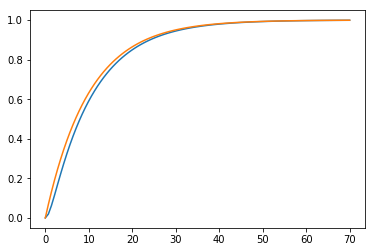

In [31]:
plotstep(G1)
plotstep(G2)

First order systems in series often have step responses which resemble those of lower order systems with increasing dead time:

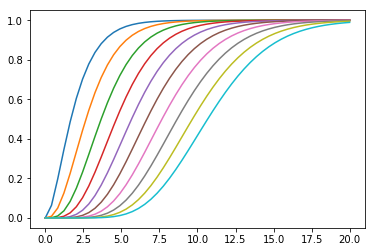

In [32]:
ts = numpy.linspace(0, 20)
G = 1/(s + 1)
for i in range(10):
    G *= 1/(s + 1)
    plotstep(G, T=ts)

If we use the 0, 1 Padé approximation of deat time dead time:

$$e^{-\theta s} \approx \frac{1}{1 + \theta s}$$

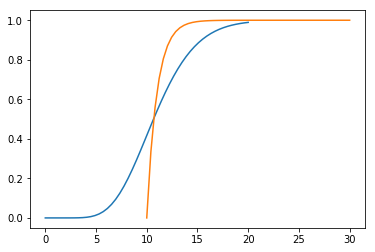

In [33]:
plotstep(G, T=ts)
plotstep(1/(s + 1), D=10, T=ts)

We see that we get the same kind of behaviour but the dynamics are too fast

We can "eyeball" a lower-order response which matches the last 10th order response pretty well:

In [34]:
def approx(tau, D):
    plotstep(G, T=numpy.linspace(0, 20))
    plotstep(1/(tau*s + 1), D=D, T=numpy.linspace(0, 20))
    plt.show()

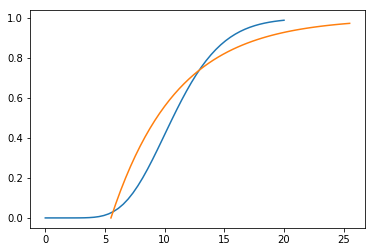

<function __main__.approx>

In [35]:
interact(approx, tau=(1., 10.), D=(1., 10.))

## Skogestad's "Half Rule"

Like the Padé and Taylor methods, this rule requires that we have a "target" for our approximation, in other words we have to decide that we will approximate our function by (say) a First Order Plus Dead Time (FOPT) model:

$$ \frac{K e^{-\theta s}}{\tau s + 1} $$

Or some other low order form. Once we know this, we know how many terms we are going to neglect.

For instance, let's take the transfer function from Example 5.4:

$$G(s) = \frac{K(-0.1s + 1)}{(5s + 1)(3s + 1)(0.5s + 1)}$$

The gains are always matched, so let's just take $K=1$

In [36]:
K = 1

In [37]:
G = K*(-0.1*s + 1)/((5*s + 1)*(3*s + 1)*(0.5*s + 1))

The "neglected time constants" are 3 and 0.5 (since we retain the highest one, 5). The largest neglected time constant is split between the dead time of the approximation and the smallest time constant of the approximation (in this case the smallest time constant of the approximation is 5).

According to the rule, we take half of the largest neglected time constant (3) and add it to the dead time (we started with no dead time, now we have $3/2=1.5$ seconds of delay. We add the other half to the smallest retained time constant ($5 + 1.5 = 6.5$). The other denominator time constants are added to the delay directly. We also add to the delay for every right hand plane zero time constant. We therefore have a total delay of 1.5 + 0.1 + 0.5 = 2.1.

Let's see what our final approximation looks like:

In [38]:
Gapprox = 1/(6.5*s + 1)
theta = 1.5 + 0.1 + 0.5

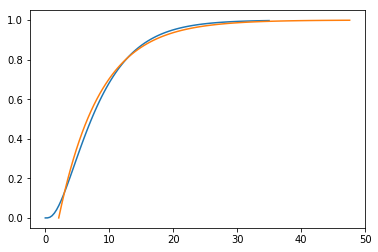

In [39]:
plotstep(G)
plotstep(Gapprox, D=theta)

Not bad!